In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

    
    
    
def Belief(State,p,r):
   
    equilibrium = r/(1-p+r);
    
    if State[0]== 0 and State[1]> 0:
            Belief = (r-r*(p-r)**(State[1]))/(1+r-p);
    elif State[0]== 1 and State[1]> 0:
            Belief = (r+(1-p)*(p-r)**(State[1]))/(1+r-p);
            
    else:
        
        Belief = equilibrium;

    return Belief;
            
        
def WhittleIndex(State,p,r):
    WhittleIndex = 0.;

    
    if State[0]== 0 and State[1]>0:
        l= State[1];
        x= Belief([0,l],p,r);
        y=Belief([0,l+1],p,r);
        WhittleIndex =((x-y)*(l+1)+y)/(1-p+(x-y)*l+y); 
    elif State[0] == 1:
        WhittleIndex = r/((1-p)*(1+r-p)+r);
    
    else:
        WhittleIndex = r/((1-p)*(1+r-p)+r);
            
    return WhittleIndex;

def update(S,C,Reward,alpha,p,r,q,s,gamma,N):
        #the update process of each timestep.
        
        #S is the list of belief states of all channels.
        #C is the list of actual channel states.
        W = [0.]*N;
        Y = [0.]*N;
        Action = [0]*N;
        Threshold = 0.;
        Seed = np.random.rand(N);
        
       #Get the Threshold. 
        for i in range(int(N*gamma)):
            Y[i]= WhittleIndex(S[i],p,r);
        for i in range(int(N*gamma),N):
            Y[i]= WhittleIndex(S[i],q,s);
        
        Y.sort();
        Threshold = Y[int((1-alpha)*N)];
        
        
        
       #Get the Action vector.
        for i in range(int(N*gamma)):
            W[i]= WhittleIndex(S[i],p,r);
        for i in range(int(N*gamma),N):
            W[i]= WhittleIndex(S[i],q,s);
    
        h=0;
        for i in range(N):
            if W[i]>= Threshold:
                Action[i]=1;
                h=h+1;
            if h >= alpha*N:
                break;
            
       #The update process.
       
        for i in range(int(N*gamma)):
        
            if Action[i] == 0 and S[i][1]>0:
                S[i][1]= S[i][1]+1;
                if C[i]==0:
                    if Seed[i]<r:
                        C[i]=1;
                    else:
                        C[i]=0;
                else:
                    if Seed[i]<p:
                        C[i]=1;
                    else:
                        C[i]=0;
                
                
                
               
             
            elif Action[i] == 0 and S[i][1]==0:
                if C[i]==0:
                    if Seed[i]<r:
                        C[i]=1;
                    else:
                        C[i]=0;
                else: 
                    if Seed[i]<p:
                        C[i]=1;
                    else:
                        C[i]=0;
            
            else:
                if C[i]==1:
                    S[i]= [1,1];
                    Reward = Reward + 1;
                    C[i]= int((Seed[i]<p)==True);
                    
                else:
                    S[i]= [0,1];
                    C[i]= int((Seed[i]<r)==True);
        
        for i in range(int(N*gamma),N):
        
            if Action[i] == 0 and S[i][1]>0:
                S[i][1]= S[i][1]+1;
                if C[i]==0:
                    if Seed[i]<s:
                        C[i]=1;
                    else:
                        C[i]=0;
                else:
                    if Seed[i]<q:
                        C[i]=1;
                    else:
                        C[i]=0;
                
                
                
               
             
            elif Action[i] == 0 and S[i][1]==0:
                if C[i]==0:
                    if Seed[i]<s:
                        C[i]=1;
                    else:
                        C[i]=0;
                else: 
                    if Seed[i]<q:
                        C[i]=1;
                    else:
                        C[i]=0;
            
            else:
                if C[i]==1:
                    S[i]= [1,1];
                    Reward = Reward + 1;
                    C[i]= int((Seed[i]<q)==True);
                    
                else:
                    S[i]= [0,1];
                    C[i]= int((Seed[i]<s)==True);
        
        
        
        return Reward;
    

def action(S,C,alpha,p,r,q,s,gamma,N):
    
    W = [0.]*N;
    Y = [0.]*N;
    Action = [0]*N;
    Threshold = 0.;
 
        
    #Get the Threshold. 
    for i in range(int(N*gamma)):
        Y[i]= WhittleIndex(S[i],p,r);
    for i in range(int(N*gamma),N):
        Y[i]= WhittleIndex(S[i],q,s);
        
    Y.sort();
    Threshold = Y[int((1-alpha)*N)];
    
    #Get the Action vector.
    for i in range(int(N*gamma)):
        W[i]= WhittleIndex(S[i],p,r);
    for i in range(int(N*gamma),N):
        W[i]= WhittleIndex(S[i],q,s);
    
    h=0;
    for i in range(N):
        if W[i]>= Threshold:
            Action[i]=1;
            h=h+1;
        if h >= alpha*N:
            break;
    
    return Action;
    
            

        
    
     
    
    


In [3]:
def average(mylist,first,last):
    sum = 0;
    
    for i in range(first,last):
        sum = sum + mylist[i];
    
    number = last - first;
    return sum/(number);

In [14]:
l=[1,5,4,8,9,7,3,5,6,5,6];
print(average(l,1,3));

4.5


In [25]:
print(update([[0,0],[0,0],[0,3],[0,2],[0,0],[1,4],[1,3],[1,7],[0,4],[0,6]],[0,0,1,0,0,1,1,0,0,0],0,0.5,0.4,0.3,0.6,0.2,0.6,10));

2


In [26]:
print(action([[0,0],[0,0],[0,3],[0,2],[0,0],[1,4],[1,3],[1,7],[0,4],[0,6]],[0,0,1,0,0,1,1,0,0,0],0.5,0.4,0.3,0.6,0.2,0.6,10));

[1, 1, 0, 0, 1, 1, 1, 0, 0, 0]


In [4]:
def onetrial(S,C,Reward,timesteps,alpha,p,r,q,s,gamma,N):

    for i in range(timesteps):
        Reward = update(S,C,Reward,alpha,p,r,q,s,gamma,N);
    return Reward;

In [5]:
print(onetrial([[0,0],[0,0],[0,3],[0,2],[0,0],[1,4],[1,3],[1,7],[0,4],[0,6]],[0,0,1,0,0,1,1,0,0,0],0,10,0.5,0.4,0.3,0.6,0.2,0.6,10));

22


In [5]:
import copy;

def mc(S,Reward,ntrials,timesteps,alpha,p,r,q,s,gamma,N):
    e_1 = r/(1-p+r);
    e_2 = s/(1-q+s);
    C = [0]*N;
    Seed = np.random.rand(N);
    for j in range(int(N*gamma)):
            C[j]= int((Seed[j]< e_1) == True);
            
    for j in range(int(N*gamma),N):
            C[j]= int((Seed[j]<e_2) == True);
   
    for i in range(ntrials):
        
        SS= copy.deepcopy(S); 
        CC= copy.deepcopy(C);
        Reward = onetrial(SS,CC,Reward,timesteps,alpha,p,r,q,s,gamma,N);
        
    lowerbound = 100*Reward/(timesteps*ntrials*N);
    
    return lowerbound;


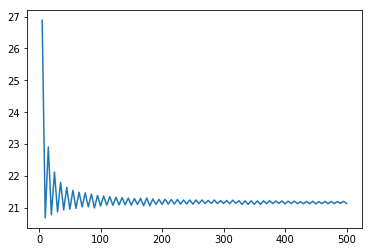

In [6]:
import numpy as np;
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,500,0.3,0.75,0.2,0.8,0.3,0.6,n);

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t);

plt.plot(t,X);

#The theoretical upper bound is 21.387

In [ ]:
import numpy as np;
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,500,0.2,0.9,1/15,0.5,1/3,0.5,n);

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t);

plt.plot(t,X);

#The theoretical upper bound is 14.756 

In [ ]:
import numpy as np;
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,500,0.7,0.9,1/15,0.5,1/3,0.5,n);

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t);

plt.plot(t,X);

#The theoretical upper bound is 35.288

In [ ]:
import numpy as np;
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,500,0.2,0.65,0.15,0.44,0.24,0.5,n);

num_processors = 16;
p=Pool(processes = num_processors);

t = list(range(5,505,5));

X = p.map(worker,t);

plt.plot(t,X);

#The theoretical upper bound is 8.802


In [5]:
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,1000,0.7,0.9,1/15,0.5,1/3,0.5,n);

num_processors=8;

p=Pool(processes = num_processors);

output = p.map(worker,[100,150,200,250,300,350,400,450]);

print(output);





[34.698542, 34.79093066666667, 34.794073, 34.8628808, 34.869024, 34.85742742857143, 34.9125935, 34.92322844444445]


In [6]:
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*n,0,500,1000,0.3,0.9,1/15,0.5,1/3,0.5,n);

num_processors=10;

p=Pool(processes = num_processors);

output = p.map(worker,[100,200,300,400,500,600,700,800,900,1000]);

print(output);

[19.25345, 19.285233, 19.281751333333332, 19.292742, 19.2862548, 19.283928333333332, 19.282546571428572, 19.28469675, 19.27811022222222, 19.2789802]


In [7]:
from multiprocessing import Pool
def worker(n):
    return mc([[0,0]]*2000,0,n,1000,0.3,0.9,1/15,0.5,1/3,0.5,2000);

num_processors=16;

p=Pool(processes = num_processors);

output = p.map(worker,[30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]);

print(output);

[19.289173333333334, 19.288685483870967, 19.288515625, 19.289439393939393, 19.287605882352942, 19.287685714285715, 19.286118055555555, 19.286617567567568, 19.286126315789474, 19.286785897435898, 19.287945, 19.286665853658537, 19.286102380952382, 19.285162790697676, 19.2849875, 19.285695555555556]


In [27]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.5,0.4,0.3,0.6,0.2,0.6,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200)];

#For this set of parameters, the performance of the two policies are nearly the same, but we clearly see
#the increasing tendance of the performance with N, the toral number of channels!

#The upperbound calculated is 19.338
    

18.57298
18.48417
18.48102
18.49588
18.512772
18.602192
18.677435


In [28]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.7,0.9,1/15,0.5,1/3,0.5,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200)];

#For this set of parameters, the performance of the two policies are still nearly the same,
#beacause alpha = 0.7 is large and a large portion of channel will be in Belief State [1,1], so
#the two policies will not distinguish between them!

#But still, we observe the increasing of performance with N, the total number of channels!
#That's a good news!!!

#The upperbound calculated is 35.288
    

34.21854
34.38348
34.44988
34.486515
34.554204
34.720798
34.821584


In [29]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.65,0.15,0.44,0.24,0.5,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200)];

#For this set of parameters, WhittleIndex Policy performs much better than the BeliefGreedy policy!
#Because the alpha = 0.2 is small and most of the channel will in Belief States [0,*], and we see 
#from the WhittleIndex Plot that there is a 'cross' just after 3 units of time!


#The upperbound calculated is 8.802

8.44704
8.40003
8.39524
8.395085
8.39588
8.404906
8.43877


In [30]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.9,1/15,0.5,1/3,0.5,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200)];

#To again verify my theory, I retest the second example with an alpha of 0.2 instead of 0.7 while keeping the 
#other parameters unchanged, to see if we will make a bigger performance difference in the two policies.

#The upperbound calculated is 14.756


13.97262
14.10359
14.14778
14.13342
14.154176
14.15611
14.172237


In [ ]:
#It's nearly 4 percent of performence improvement compare to the BeliefGreedy!!!!!!

In [7]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.9,1/15,0.5,1/3,0.5,N);
    return lb;

y= [lb(1000),lb(1500),lb(2000),lb(5000)];

14.268247
14.325816933333334
14.3709044
14.4731894


In [ ]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.65,0.15,0.44,0.24,0.5,N);
    return lb;

y= [lb(1000),lb(1500),lb(2000),lb(5000)];

In [ ]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.9,1/15,0.5,1/3,0.5,N);
    return lb;

y= [lb(10000),lb(15000)];

14.49063534
14.496452493333333


In [7]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.2,0.9,1/15,0.5,1/3,0.5,N);
    return lb;

y= [lb(20000),lb(50000),lb(100000)]; 

14.49964304
14.508246632
14.512805012


In [6]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.3,0.75,0.2,0.8,0.3,0.6,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200),lb(300),lb(400),lb(500)];

#The upper bound is 21.387242178866277

20.7233
20.82542
20.888073333333335
20.95328
21.002976
21.119846
21.169105
21.184108
21.18744
21.18573


In [29]:
def lb(N):
    lb= mc([[0,0]]*N,0,500,1000,0.3,0.75,0.2,0.8,0.3,0.6,N);
    return lb;

y= [lb(10),lb(20),lb(30),lb(40),lb(50),lb(100),lb(200),lb(300),lb(400),lb(500)];

20.73388
20.82258
20.87802
20.93655
20.99834
21.103274
21.139594
21.15557
21.1642825
21.1637424


In [8]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [20]:
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

[[2, 9, 8, 2, 9],
 [0, 0, 7, 8, 1],
 [9, 0, 8, 8, 6],
 [3, 6, 7, 8, 9],
 [8, 2, 9, 7, 8]]

In [25]:
def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))

print(results[:11])

[1, 2, 3, 3, 3, 4, 2, 3, 2, 1, 2]
